### London Social Infrastructure Recipe

##### Using OSM Data the recipe aims at counting the Health Count, Education Count and Civic Count amenities

##### About Social Infrastructure

###### Our social infrastructure index uses OpenStreetMap data to demonstrate how many items of social infrastructure are tagged on 
###### OpenStreetMap within each Lower Super Output Area. We have segmented social infrastructure into three categories:

##### Education tags include:

    - School
    - Library
    - University
    - College
    - Kindergarten

##### Heath tags include:

    - Clinic
    - Dentist
    - Doctors
    - Hospital
    - Pharmacy

##### Civic tags include:

    - courthouse
    - coworking_space
    - bench
    - fire_station
    - place_of_worship
    - police
    - post-box
    - post_office
    - public_bath
    - recycling
    - town_hall
    - waste_disposal

###### A value of 10 suggests that there are 10 social amenities in that LSOA. 
###### This value represents the summation of each of the categories (Education, Health and Civic) respectively.

In [1]:
import os
from pathlib import Path

home_dir = str(Path.home())
tdc = os.path.join(home_dir, 'Desktop/python_library_dc/digital-connector-python')
digital_connector = os.path.join(home_dir, 'Desktop/UptodateProject/TomboloDigitalConnector')
os.chdir(tdc)

##### Here we are importing different components required to build the recipe

In [37]:
from recipe import PercentilesField, Subject, Dataset, Geo_Match_Rule, Match_Rule, Datasource, GeographicAggregationField, AttributeMatcherField, ConstantField, AttributeMatcher, ListArithmeticField

#### Creating Main Subject

The section below creates a Match Rule which means it will only search for local authorities of London

In [3]:
match_rule_ = Match_Rule(attribute_to_match_on='label', pattern='E0900%')
inner_subject = Subject(subject_type_label='localAuthority', provider_label='uk.gov.ons', 
                       match_rule=match_rule_)
geo_match_ = Geo_Match_Rule(geo_relation='within', subjects=[inner_subject])
main_subject = Subject(subject_type_label='lsoa', provider_label='uk.gov.ons', 
                      geo_match_rule=geo_match_)

In [4]:
oa_class = 'uk.org.tombolo.importer.ons.OaImporter'
osm_class = 'uk.org.tombolo.importer.osm.OSMImporter'
geography_ = 'europe/great-britain/england/greater-london'
osm_datasource_ids = ['OSMHealth', 'OSMCivic', 'OSMEducation']
osm_datasources = []
lsoa_data = Datasource(importer_class=oa_class, datasource_id='lsoa')
la_data = Datasource(importer_class=oa_class, datasource_id='localAuthority')
osm_datasources.append(lsoa_data)
osm_datasources.append(la_data)
for datasource in osm_datasource_ids:
    osm_datasources.append(Datasource(importer_class=osm_class, datasource_id=datasource, geography_scope=[geography_]))

In [41]:
constant_field = ConstantField(value='1')
geo_sub = Subject(provider_label='org.openstreetmap', subject_type_label='OSMEntity')

field_attributes = [['amenity', 'Health Count', ['clinic', 'dentist', 'doctors', 'hospital', 'pharmacy']]]
#                    ['amenity','Education Count', ['school', 'library', 'university', 'college', 'kindergarten']],
#                    ['amenity','Civic Count', ['courthouse', 'coworking_space', 'recycling', 'fire_station', 'place_of_worship', 'police', 'post_office', 'town_hall', 'waste_disposal']]]

fields = []
for i in range(len(field_attributes)):
    attr_matcher = AttributeMatcher(provider='org.openstreetmap', label=field_attributes[i][0], 
                                   values=field_attributes[i][2])
    attr_matcher_field = AttributeMatcherField(attributes=[attr_matcher], field=constant_field, 
                                              label=field_attributes[i][0])
    geo_agg_field = GeographicAggregationField(subject=geo_sub, function='sum', 
                                               field=attr_matcher_field, label=field_attributes[i][1])
    fields.append(geo_agg_field)


In [42]:
arthmetic_field = ListArithmeticField(operation='add', fields=fields, label='Sum of civic amenities')

perc = PercentilesField(field=arthmetic_field,inverse=False,percentile_count=10,label='jsd')

In [43]:
all_fields = [x for x in fields]
all_fields.append(arthmetic_field)
dataset = Dataset(subjects=[main_subject], datasources=osm_datasources, fields=[perc])

In [ ]:
dataset.build_and_run(tombolo_path=digital_connector, model_output_location=home_dir + '/london-social-infra.json', 
                     recipe_console_print=True, model_output_console_print=True)

In [28]:
import geopandas as gpd

In [29]:
merged_data = gpd.read_file(home_dir + '/london-social-infra.json')
merged_data.head()

,Civic Count,Sum of civic amenities,name,Health Count,label,Education Count,geometry
0,3.0,3.0,City of London 001A,0.0,E01000001,0.0,"POLYGON ((-0.0973 51.5216, -0.0965 51.5203, -0..."
1,2.0,7.0,City of London 001B,1.0,E01000002,4.0,"POLYGON ((-0.0881 51.5194, -0.0893 51.5175, -0..."
2,1.0,2.0,City of London 001C,1.0,E01000003,0.0,"POLYGON ((-0.0968 51.5233, -0.0964 51.5228, -0..."
3,5.0,10.0,City of London 001E,3.0,E01000005,2.0,"POLYGON ((-0.0732 51.51, -0.0755 51.5097, -0.0..."
4,0.0,0.0,Barking and Dagenham 016A,0.0,E01000006,0.0,"POLYGON ((0.0912 51.5391, 0.09329999999999999 ..."


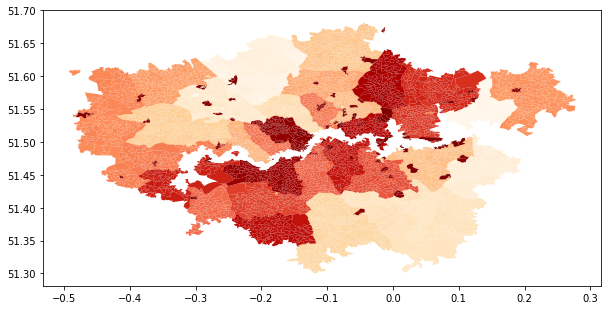

In [32]:
import matplotlib.pyplot as plt
merged_data.plot(cmap='OrRd', figsize=(10,8))

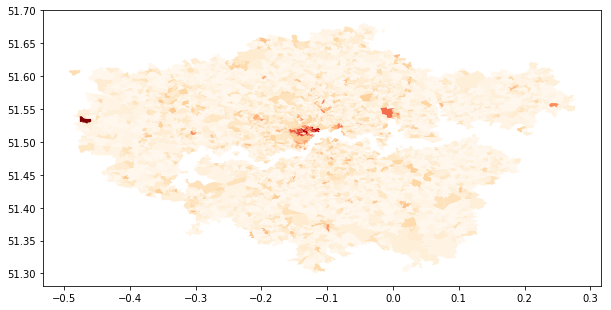

In [31]:
merged_data.plot(column='Sum of civic amenities', cmap='OrRd', figsize=(10,8))